In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal
from scipy import *
import copy


---
Mean-smooth a time series
---


In [ ]:
# create signal
srate = 1000 # Hz
time  = np.arange(0,3,1/srate)
n     = len(time)
p     = 15 # poles for random interpolation

# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
ampl   = np.interp(np.linspace(0,p,n),np.arange(0,p),np.random.rand(p)*30)
noise  = noiseamp * np.random.randn(n)
signal = ampl + noise

# initialize filtered signal vector
filtsig = np.zeros(n)

# implement the running mean filter
k =20# filter window is actually k*2+1
for i in range(k,n-k):
    # each point is the average of k surrounding points
    filtsig[i] = np.mean(signal[i-k:i+k])

# compute window size in ms
windowsize = 1000*(k*2+1) / srate


# plot the noisy and filtered signals
plt.plot(time,signal,label='orig')
plt.plot(time,filtsig,label='filtered')

plt.legend()
plt.xlabel('Time (sec.)')
plt.ylabel('Amplitude')
plt.title('Running-mean filter with a k=%d-ms filter' %windowsize)

plt.show()



---
Gaussian-smooth a time series
---


In [ ]:
# create signal
srate = 1000 # Hz
time  = np.arange(0,3,1/srate)
n     = len(time)
p     = 15 # poles for random interpolation

# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
ampl   = np.interp(linspace(1,p,n),np.arange(0,p),np.random.rand(p)*30)
noise  = noiseamp * np.random.randn(n)
signal = ampl + noise

## create Gaussian kernel
# full-width half-maximum: the key Gaussian parameter
fwhm = 25 # in ms

# normalized time vector in ms
k = 100
# gtime = 1000*np.arange(-k,k)/srate
gtime = np.arange(-k,k)
# create Gaussian window
gauswin = np.exp( -(4*np.log(2)*gtime**2) / fwhm**2 )

# compute empirical FWHM
pstPeakHalf = k + np.argmin( (gauswin[k:]-.5)**2 )
prePeakHalf = np.argmin( (gauswin-.5)**2 )

empFWHM = gtime[pstPeakHalf] - gtime[prePeakHalf]

# show the Gaussian
plt.plot(gtime,gauswin,'ko-')
plt.plot([gtime[prePeakHalf],gtime[pstPeakHalf]],[gauswin[prePeakHalf],gauswin[pstPeakHalf]],'m')

# then normalize Gaussian to unit energy
gauswin = gauswin / np.sum(gauswin)
# title([ 'Gaussian kernel with requeted FWHM ' num2str(fwhm) ' ms (' num2str(empFWHM) ' ms achieved)' ])
plt.xlabel('Time (ms)')
plt.ylabel('Gain')

plt.show()

In [ ]:
## implement the filter

# initialize filtered signal vector
filtsigG = copy.deepcopy(signal)

# # implement the running mean filter
for i in range(k+1,n-k):
    # each point is the weighted average of k surrounding points
    filtsigG[i] = np.sum( signal[i-k:i+k]*gauswin )

# plot
plt.plot(time,signal,'r',label='Original')
plt.plot(time,filtsigG,'k',label='Gaussian-filtered')

plt.xlabel('Time (s)')
plt.ylabel('amp. (a.u.)')
plt.legend()
plt.title('Gaussian smoothing filter')

## for comparison, plot mean smoothing filter

# initialize filtered signal vector
filtsigMean = copy.deepcopy(signal)

# implement the running mean filter
# note: using mk instead of k to avoid confusion with k above
mk = 20 # filter window is actually mk*2+1
for i in range(mk+1,n-mk-1):
    # each point is the average of k surrounding points
    filtsigMean[i] = mean(signal[i-mk:i+mk])

plt.plot(time,filtsigMean,'b',label='Running mean')
plt.legend()
plt.show()

In [ ]:

# number of spikes
n = 10

# inter-spike intervals (exponential distribution for bursts)
isi = np.round(np.exp( np.random.randn(n) )*10)
print(isi)
# generate spike time series
spikets = np.zeros(int(sum(isi)))
for i in range(0,n):
    print(int(np.sum(isi[0:i])))



---
Gaussian-smooth a spike time series
---


In [ ]:
## generate time series of random spikes

# number of spikes
n = 10

# inter-spike intervals (exponential distribution for bursts)
isi = np.round(np.exp( np.random.randn(n) )*10)
print(isi)
# generate spike time series
spikets = np.zeros(int(sum(isi)))
for i in range(0,n):
    spikets[ int(np.sum(isi[0:i])) ] = 1
    print(spikets)

# plot
plt.plot(spikets)
# plt.xlim([50,100])
plt.xlabel('Time (a.u.)')
plt.show()

In [ ]:
## create and implement Gaussian window

# full-width half-maximum: the key Gaussian parameter
fwhm = 25 # in points

# normalized time vector in ms
k = 100;
gtime = np.arange(-k,k)

# create Gaussian window
gauswin = np.exp( -(4*log(2)*gtime**2) / fwhm**2 )
gauswin = gauswin / np.sum(gauswin)

# initialize filtered signal vector
filtsigG = np.zeros(len(spikets))

# implement the weighted running mean filter
for i in range(k+1,len(spikets)-k):
    filtsigG[i] = np.sum( spikets[i-k:i+k]*gauswin )


# plot the filtered signal (spike probability density)
plt.plot(spikets,'b',label='spikes')
plt.plot(filtsigG,'r',label='spike p.d.')
plt.legend()
plt.title('Spikes and spike probability density')
plt.show()

In [ ]:

print(emgdata.keys())


---
Denoising via TKEO
---


In [ ]:
# import data
emgdata = sio.loadmat('emg4TKEO.mat')

# extract needed variables
emgtime = emgdata['emgtime'][0]
emg  = emgdata['emg'][0]

# initialize filtered signal
emgf = copy.deepcopy(emg)

# the loop version for interpretability
for i in range(1,len(emgf)-1):
    emgf[i] = emg[i]**2 - emg[i-1]*emg[i+1]

# the vectorized version for speed and elegance
emgf2 = copy.deepcopy(emg)
emgf2[1:-1] = emg[1:-1]**2 - emg[0:-2]*emg[2:]

## convert both signals to zscore

# find timepoint zero
time0 = np.argmin(emgtime**2)

# convert original EMG to z-score from time-zero
emgZ = (emg-np.mean(emg[0:time0])) / np.std(emg[0:time0])

# same for filtered EMG energy
emgZf = (emgf-np.mean(emgf[0:time0])) / std(emgf[0:time0])

## plot
# plot "raw" (normalized to max.1)
plt.plot(emgtime,emg/np.max(emg),'b',label='EMG')
plt.plot(emgtime,emgf/np.max(emgf),'m',label='TKEO energy')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude or energy')
plt.legend()

plt.show()

# plot zscored
plt.plot(emgtime,emgZ,'b',label='EMG')
plt.plot(emgtime,emgZf,'m',label='TKEO energy')

plt.xlabel('Time (ms)')
plt.ylabel('Zscore relative to pre-stimulus')
plt.legend()
plt.show()

In [ ]:
50 + np.random.rand(100)*100

In [ ]:
n = 2000
signal = np.cumsum(np.random.randn(n))
noisepoints = np.random.permutation(n)
noisepoints = noisepoints[0:int(n*0.05)]
print(len(noisepoints))
signal[noisepoints] = 50 + np.random.rand(len(noisepoints))*100
plt.plot(signal)
plt.show()
plt.hist(signal)
plt.show()



In [ ]:

    

threshold = 25
exceed_thres = np.where(signal > threshold)[0]
print(exceed_thres)
filtsig = copy.deepcopy(signal)

# apply median filter
k = 20
for i in range(len(exceed_thres)):
    lowbnd = np.max((0,exceed_thres[i]-k))
    upbnd = np.min((exceed_thres[i]+k,n+1))
    
    filtsig[exceed_thres[i]] = np.median(signal[lowbnd:upbnd])

plt.plot(signal)
plt.plot(filtsig)
plt.show()


---
Median filter to remove spike noise
---


In [ ]:
# create signal
n = 2000
signal = np.cumsum(np.random.randn(n))


# proportion of time points to replace with noise
propnoise = .05

# find noise points
noisepnts = np.random.permutation(n)
noisepnts = noisepnts[0:int(n*propnoise)]

# generate signal and replace points with noise
signal[noisepnts] = 50+np.random.rand(len(noisepnts))*100


# use hist to pick threshold
plt.hist(signal,100)
plt.show()

# visual-picked threshold
threshold = 40


# find data values above the threshold
suprathresh = np.where( signal>threshold )[0]

# initialize filtered signal
filtsig = copy.deepcopy(signal)

# loop through suprathreshold points and set to median of k
k = 20 # actual window is k*2+1
for ti in range(len(suprathresh)):
    
    # lower and upper bounds
    lowbnd = np.max((0,suprathresh[ti]-k))
    uppbnd = np.min((suprathresh[ti]+k,n+1))
    
    # compute median of surrounding points
    filtsig[suprathresh[ti]] = np.median(signal[lowbnd:uppbnd])

# plot
plt.plot(range(0,n),signal, range(0,n),filtsig)
plt.show()


In [ ]:
# create brownian noise 
n = 2000
noise = np.cumsum(np.random.randn(n))
signal = np.linspace(-30,30,n) + noise
plt.plot(signal)


detrended = scipy.signal.detrend(signal)
plt.plot(detrended)


---
Remove linear trend
---


In [ ]:
# create signal with linear trend imposed
n = 2000
signal = np.cumsum(np.random.randn(n)) + np.linspace(-30,30,n)

# linear detrending
detsignal = scipy.signal.detrend(signal)

# get means
omean = np.mean(signal) # original mean
dmean = np.mean(detsignal) # detrended mean

# plot signal and detrended signal
plt.plot(range(0,n),signal,label='Original, mean=%d' %omean)
plt.plot(range(0,n),detsignal,label='Detrended, mean=%d' %dmean)

plt.legend()
plt.show()

In [ ]:
# polynomial intuition 
order = 2
x = np.linspace(-30,30,100)
y = np.zeros(len(x))
for i in range(order+1):
    y += np.random.randn(1)*x**i
plt.plot(x,y)
plt.title('order %d polynomial' %order)
plt.show()


---
Remove nonlinear trend with polynomials
---


In [ ]:
## polynomial intuition

order = 2
x = np.linspace(-15,15,100)

y = np.zeros(len(x))

for i in range(order+1):
    y = y + np.random.randn(1)*x**i

plt.plot(x,y)
plt.title('Order-%d polynomial' %order)
plt.show()


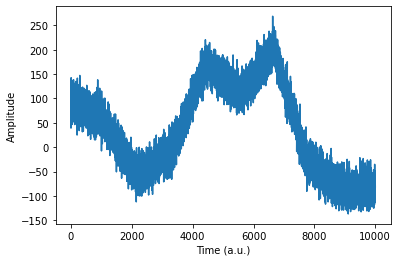

In [25]:
## generate signal with slow polynomial artifact

n = 10000
t = range(n)
k = 10 # number of poles for random amplitudes

slowdrift = np.interp(np.linspace(1,k,n),np.arange(0,k),100*np.random.randn(k))
signal = slowdrift + 20*np.random.randn(n)

# plot
plt.plot(t,signal)
plt.xlabel('Time (a.u.)')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
## fit a 3-order polynomial

# polynomial fit (returns coefficients)
p = polyfit(t,signal,3)

# predicted data is evaluation of polynomial
yHat = polyval(p,t)

# compute residual (the cleaned signal)
residual = signal - yHat


# now plot the fit (the function that will be removed)
plt.plot(t,signal,'b',label='Original')
plt.plot(t,yHat,'r',label='Polyfit')
plt.plot(t,residual,'k',label='Filtered signal')

plt.legend()
plt.show()

In [ ]:
## Bayes information criterion to find optimal order

# possible orders
orders = range(5,40)

# sum of squared errors (sse is reserved!)
sse1 = np.zeros(len(orders))

# loop through orders
for ri in range(len(orders)):
    
    # compute polynomial (fitting time series)
    yHat = np.polyval(polyfit(t,signal,orders[ri]),t)
    
    # compute fit of model to data (sum of squared errors)
    sse1[ri] = np.sum( (yHat-signal)**2 )/n


# Bayes information criterion
bic = n*np.log(sse1) + orders*np.log(n)

# best parameter has lowest BIC
bestP = min(bic)
idx = np.argmin(bic)

# plot the BIC
plt.plot(orders,bic,'ks-')
plt.plot(orders[idx],bestP,'ro')
plt.xlabel('Polynomial order')
plt.ylabel('Bayes information criterion')
plt.show()

In [ ]:
## now repeat filter for best (smallest) BIC

# polynomial fit
polycoefs = polyfit(t,signal,orders[idx])

# estimated data based on the coefficients
yHat = polyval(polycoefs,t)

# filtered signal is residual
filtsig = signal - yHat


## plotting
plt.plot(t,signal,'b',label='Original')
plt.plot(t,yHat,'r',label='Polynomial fit')
plt.plot(t,filtsig,'k',label='Filtered')

plt.xlabel('Time (a.u.)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


---
Averaging multiple repetitions (time-synchronous averaging)
---


In [33]:
onsettimes = np.random.permutation(10000-k)
onsettimes = onsettimes[0:30]
print(onsettimes)

[7919 2945 5166 1505 1523 5888 9774 8288 5871 3576  360 9106 3354 1149
 4219 7306 8996 1274 1587  284 3547 4040 5414  682 7213 1014 8925 4701
 2622 1828]


In [ ]:
data = np.zeros(10000)


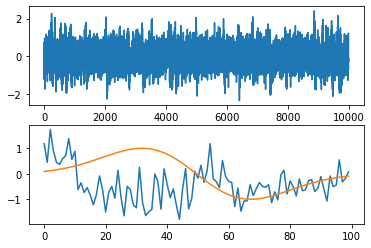

In [34]:
## simulate data

# create event (derivative of Gaussian)
k = 100 # duration of event in time points
event = np.diff(np.exp( -np.linspace(-2,2,k+1)**2 ))
event = event/np.max(event) # normalize to max=1

# event onset times
Nevents = 30
onsettimes = np.random.permutation(10000-k)
onsettimes = onsettimes[0:Nevents]

# put event into data
data = np.zeros(10000)
for ei in range(Nevents):
    data[onsettimes[ei]:onsettimes[ei]+k] = event

# add noise
data = data + .5*np.random.randn(len(data))

# plot data
plt.subplot(211)
plt.plot(data)

# plot one event
plt.subplot(212)
plt.plot(range(k), data[onsettimes[3]:onsettimes[3]+k])
plt.plot(range(k), event)
plt.show()

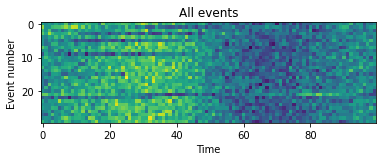

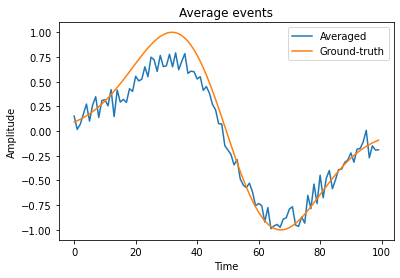

In [35]:
## extract all events into a matrix

datamatrix = np.zeros((Nevents,k))

for ei in range(Nevents):
    datamatrix[ei,:] = data[onsettimes[ei]:onsettimes[ei]+k]

plt.imshow(datamatrix)
plt.xlabel('Time')
plt.ylabel('Event number')
plt.title('All events')
plt.show()

plt.plot(range(0,k),np.mean(datamatrix,axis=0),label='Averaged')
plt.plot(range(0,k),event,label='Ground-truth')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Average events')
plt.show()


---
Remove artifact via least-squares template-matching
---


In [13]:
# load dataset
matdat = sio.loadmat('templateProjection.mat')
EEGdat = matdat['EEGdat']
eyedat = matdat['eyedat']
timevec = matdat['timevec'][0]
MN = np.shape(EEGdat) # matrix sizes

# initialize residual data
resdat = zeros(np.shape(EEGdat))


# loop over trials
for triali in range(MN[1]):
    
    # build the least-squares model as intercept and EOG from this trial
    X = np.column_stack((np.ones(MN[0]),eyedat[:,triali]))
    
    # compute regression coefficients for EEG channel
    b = np.linalg.solve(np.matrix.transpose(X)@X,np.matrix.transpose(X)@EEGdat[:,triali])
    
    # predicted data
    yHat = X@b
    
    # new data are the residuals after projecting out the best EKG fit
    resdat[:,triali] = EEGdat[:,triali] - yHat

<ipython-input-13-13a09241e2c6>:9: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  resdat = zeros(np.shape(EEGdat))


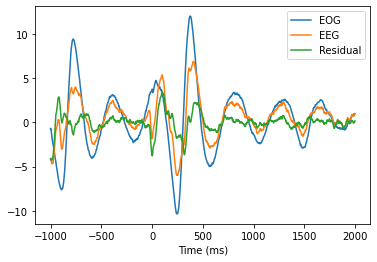

In [14]:
### plotting

# trial averages
plt.plot(timevec,np.mean(eyedat,axis=1),label='EOG')
plt.plot(timevec,np.mean(EEGdat,axis=1),label='EEG')
plt.plot(timevec,np.mean(resdat,1),label='Residual')

plt.xlabel('Time (ms)')
plt.legend()
plt.show()

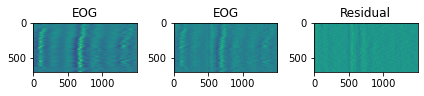

In [15]:
# show all trials in a m ap
clim = [-1,1]*20

plt.subplot(131)
plt.imshow(eyedat.T)
plt.title('EOG')


plt.subplot(132)
plt.imshow(EEGdat.T)
plt.title('EOG')


plt.subplot(133)
plt.imshow(resdat.T)
plt.title('Residual')

plt.tight_layout()
plt.show()